In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [24]:
df_pow = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/pow_inv-32-A_5min.pkl')
df_POA = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/poa_5min.pkl')
df_Tmod = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/tmod_5min.pkl')
df_met = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/met_5min.pkl')
df_T = df_met[['Temp','Timestamp']]
df_T = df_T.rename(columns={'Temp': 'Temp','Timestamp': 'time'})

df_inner = pd.merge(df_pow, df_POA, on='time', how='inner')
df_inner2 = pd.merge(df_inner, df_Tmod, on='time', how='inner')
df = pd.merge(df_inner2, df_T, on='time', how='inner')

df.set_index('time', inplace=True)
df = df.rename(columns={'power': 'Power','value_x': 'POA','value_y': 'Tmod' })

print(df.shape)
print(df.columns)

(113472, 4)
Index(['Power', 'POA', 'Tmod', 'Temp'], dtype='object')


In [25]:
## Define the morning hour range
#start_hour = 6
#end_hour = 21
## Filter rows based on morning hour range
#df = df[(df.index.hour >= start_hour) & (df.index.hour < end_hour)]
#print(df.shape)

In [26]:
#df = df[df['POA']>0]
#df = df[df['Power']>0]
#print(df.shape)

In [27]:
# Solar panel = JKM345M-72-V x 5742 panels
POA_std = 1000
Capacity = 5742*345/1000000
T_std = 25 
#T_std = df['Tmod'].mean()
alpha = -0.004

'''
start_date = '2023-11-20'
end_date = '2023-11-22'

test = (df['Power'][start_date:end_date])/(Capacity*(1 + alpha*(df['Tmod'][start_date:end_date] - T_std))*df['POA'][start_date:end_date]/POA_std)
print(test)
test.replace([np.inf, -np.inf], np.nan, inplace=True)
temp = test.dropna()
P_constant = np.mean(temp[temp>0])
P_constant = np.mean(temp)
print(P_constant)
'''

df['shifted_Power'] = df['Power'] 
df.loc['2023-04-02':'2023-09-30', 'shifted_Power'] = df.loc['2023-04-02':'2023-09-30', 'Power'].shift(periods=60, freq='T')


P_constant = 1.0
df['Power_calculated'] = P_constant*Capacity*(1 + alpha*(df['Tmod'] - T_std))*df['POA']/POA_std
df['Power_error'] = df['Power_calculated'] - df['shifted_Power']


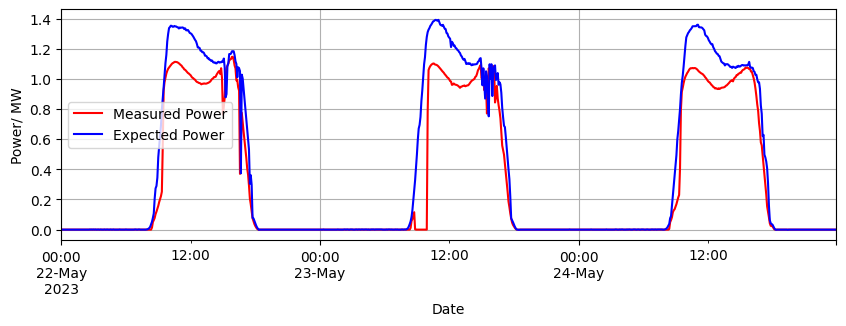

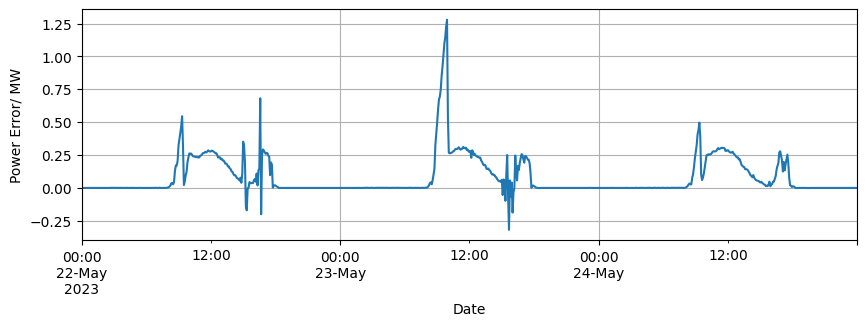

In [28]:
# Define the period you want to plot
start_date = '2023-05-22'
end_date = '2023-05-24'

#start_date = df.index.min()
#end_date = df.index.max()


# Slice the DataFrame based on the specified period
df['shifted_Power'][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Red'],label='Measured Power')
df['Power_calculated'][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Blue'],label='Expected Power')
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()


ax = df['Power_error'][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3))
plt.ylabel('Power Error/ MW')
plt.xlabel('Date')
plt.grid(True)
plt.show()

In [29]:
df.shape

(113472, 7)

In [30]:
df.describe()

,Power,POA,Tmod,Temp,shifted_Power,Power_calculated,Power_error
count,113472.000000,113472.000000,113472.000000,113472.000000,113460.000000,113472.000000,113460.000000
mean,0.296731,233.306539,17.490338,15.354025,0.296762,0.436020,0.139304
std,0.513418,374.776575,16.046519,33.016471,0.513436,0.691944,0.641691
min,0.000000,-1.139593,-6.118014,0.000000,0.000000,-0.002292,-1.700100
25%,0.000000,-0.054264,4.311919,7.100000,0.000000,-0.000116,-0.001209
50%,0.000061,0.000000,13.214670,13.800000,0.000061,0.000000,-0.000113
75%,0.408688,403.147500,28.085210,20.400000,0.408852,0.785646,0.141633
max,1.700452,1502.591000,68.853870,655.260000,1.700452,2.816438,2.816438


In [31]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

# Example: Generate synthetic time series data (replace with your own data loading)
np.random.seed(42)

# Define the period you want to plot
start_date = df.index.min()
end_date = df.index.max()

temp = df[start_date:end_date][['Power','Power_error']].resample('5min').mean()
print(temp.isnull().any().any())
print(np.any(np.isinf(temp)))
print(temp.shape)
temp_cleaned = temp.dropna()
print(temp_cleaned.shape)
data = temp_cleaned.values
print(temp_cleaned.index)


full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='5min')
temp_cleaned_reindexed = temp_cleaned.reindex(full_date_range)

df_ffill = temp_cleaned_reindexed.ffill()

if df_ffill.isnull().values.any():
    df_filled = df_ffill.bfill()
else:
    df_filled = df_ffill

True
False
(113472, 2)
(113460, 2)
DatetimeIndex(['2023-02-01 00:00:00', '2023-02-01 00:05:00',
               '2023-02-01 00:10:00', '2023-02-01 00:15:00',
               '2023-02-01 00:20:00', '2023-02-01 00:25:00',
               '2023-02-01 00:30:00', '2023-02-01 00:35:00',
               '2023-02-01 00:40:00', '2023-02-01 00:45:00',
               ...
               '2024-02-29 23:10:00', '2024-02-29 23:15:00',
               '2024-02-29 23:20:00', '2024-02-29 23:25:00',
               '2024-02-29 23:30:00', '2024-02-29 23:35:00',
               '2024-02-29 23:40:00', '2024-02-29 23:45:00',
               '2024-02-29 23:50:00', '2024-02-29 23:55:00'],
              dtype='datetime64[ns]', name='time', length=113460, freq=None)


In [32]:
# Normalize data
#scaler = MinMaxScaler()
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

In [34]:
# Create sequences/windows
'''
timesteps = 5 # Length of each sequence/window
num_sequences = len(data_normalized) - timesteps + 1

# Initialize an array to hold the sequences
sequences = np.zeros((num_sequences, timesteps, 1))

for i in range(num_sequences):
    sequences[i] = data_normalized[i:i + timesteps].reshape(-1, 1)

# Print the shape of the resulting three-dimensional array
print("Shape of the sequences array:", sequences.shape)
'''


## Create sequences for LSTM
#def create_sequences(data, timesteps):
#    sequences = []
#    for i in range(len(data) - timesteps):
#        seq = data[i+timesteps-2:i + timesteps]
#        sequences.append(seq)
#    return np.array(sequences)

## Create sequences for LSTM
#def create_sequences(data, timesteps):
#    sequences = []
#    num_sequences = (len(data) - timesteps) // timesteps + 1
#    for i in range(num_sequences):
#        start = i * (timesteps-5)
#        end = start + timesteps
#        if end <= len(data):  # Ensure we don't exceed data length
#            sequences.append(data[start:end])
#    return np.array(sequences)


def create_sequences(data, timesteps, overlap):
    sequences = []
    step_size = timesteps - overlap
    num_sequences = (len(data) - timesteps) // step_size + 1
    
    for i in range(num_sequences):
        start = i * step_size
        end = start + timesteps
        if end <= len(data):  # Ensure we don't exceed data length
            sequences.append(data[start:end])
    
    return np.array(sequences)


# Train-test split
#X_train, X_test = train_test_split(sequences, test_size=0.2, random_state=42)

# Define the split ratio
train_ratio = 1.0
test_ratio = 0.0
num_train_samples = int(train_ratio * len(data_normalized))

# Split the data
train_data = data_normalized[:num_train_samples]
test_data = data_normalized[num_train_samples:]

train_data_date = temp_cleaned.index[:num_train_samples]
test_data_date = temp_cleaned.index[num_train_samples:]


timesteps = 24  # Example sequence leng|th
train_sequences = create_sequences(train_data, timesteps,4)
test_sequences = create_sequences(test_data, timesteps,4)

print("Shape of the train sequences array:", train_sequences.shape)
print("Shape of the test sequences array:", test_sequences.shape)

Shape of the train sequences array: (5672, 24, 2)
Shape of the test sequences array: (0,)


In [35]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Attention, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

# Function to sample from the latent space
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Hyperparameters
input_dim = 1   
latent_dim = 10
dropout_rate = 0


# Encoder
inputs = Input(shape=(timesteps, input_dim),name='encoder_input')
lstm = LSTM(64, return_sequences=True, name='encoder_lstm1')(inputs)
lstm = LSTM(64, return_sequences=True, name='encoder_lstm2')(lstm)
attention = Attention(name='encoder_attention')([lstm, lstm])
concat = Concatenate(name='encoder_concat')([lstm, attention])
lstm_out = LSTM(64, name='encoder_lstm3')(concat)
z_mean = Dense(latent_dim, name='z_mean')(lstm_out)
z_log_var = Dense(latent_dim, name='z_log_var')(lstm_out)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


# Decoder
#decoder_input = Input(shape=(latent_dim,), name='decoder_input')
decoder_repeat = RepeatVector(timesteps, name='decoder_repeat')(z)
decoder_lstm1 = LSTM(64, return_sequences=True, name='decoder_lstm1')(decoder_repeat)
decoder_lstm2 = LSTM(64, return_sequences=True, name='decoder_lstm2')(decoder_lstm1)
decoder_output = TimeDistributed(Dense(input_dim), name='decoder_output')(decoder_lstm2)
    
# VAE model
vae = Model(inputs, decoder_output, name='vae')
encoder = Model(inputs, z_mean, name='encoder')

'''
# Encoder
inputs = Input(shape=(timesteps, input_dim))
h = LSTM(64, return_sequences=True,dropout=dropout_rate, recurrent_dropout=dropout_rate)(inputs)
h = LSTM(32)(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
#decoder_h1 = Dense(64)
decoder_repeat = RepeatVector(timesteps)
decoder_h2 = LSTM(32, return_sequences=True)
decoder_lstm = LSTM(64, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate)
decoder_output = TimeDistributed(Dense(input_dim))

#z = decoder_h1(z)
h_decoded = decoder_repeat(z)
h_decoded = decoder_h2(h_decoded)
x_decoded_mean = decoder_lstm(h_decoded)
x_decoded_mean = decoder_output(x_decoded_mean)


# VAE model
vae = Model(inputs, x_decoded_mean)
'''


# Loss function
reconstruction_loss = mse(K.flatten(inputs), K.flatten(decoder_output))
reconstruction_loss *= timesteps * input_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + 0.5*kl_loss)
vae.add_loss(vae_loss)

batch_size = 64

checkpoint_callback = ModelCheckpoint(
    filepath='/home/ahilan/gen-research/neoen-site/models/anomaly_detection/power_loss/neoen_one_year_data_lstm_atten/model_checkpoint_{epoch:02d}.h5',
    save_freq=5 * len(train_sequences) // batch_size,  # Change this to 'batch' to save after every batch
    verbose=1  # Set to 1 for verbose logging, 0 for silent
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss', # Monitor the validation loss
    patience=10, # Stop after 10 epochs of no improvement
    verbose=1
)

# Compile model
optimizer = Adam(learning_rate=1e-3)
vae.compile(optimizer=optimizer)
vae.summary()


# Train the VAE with early stopping
#history = vae.fit(train_sequences[:,:,1], epochs=200, batch_size=64, callbacks=[checkpoint_callback])
history = vae.fit(train_sequences[:,:,1], epochs=200, batch_size=64, validation_split=0.2, callbacks=[early_stopping_callback, checkpoint_callback])

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 24, 1)]              0         []                            
                                                                                                  
 encoder_lstm1 (LSTM)        (None, 24, 64)               16896     ['encoder_input[0][0]']       
                                                                                                  
 encoder_lstm2 (LSTM)        (None, 24, 64)               33024     ['encoder_lstm1[0][0]']       
                                                                                                  
 encoder_attention (Attenti  (None, 24, 64)               0         ['encoder_lstm2[0][0]',       
 on)                                                                 'encoder_lstm2[0][0]']     

2024-08-02 08:38:30.321806: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2400 num_cores: 40 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 14417920 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


 3/71 [>.............................] - ETA: 12s - loss: 21.8581 

KeyboardInterrupt: 

In [15]:
vae = tf.keras.models.load_model('/home/ahilan/gen-research/neoen-site/models/anomaly_detection/power_loss/neoen_one_year_data_lstm_atten/model_checkpoint_32.h5')

2024-08-02 08:27:02.493885: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


2024-08-02 08:27:15.492371: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2400 num_cores: 40 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 14417920 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


887/887 [==============================] - 14s 12ms/step


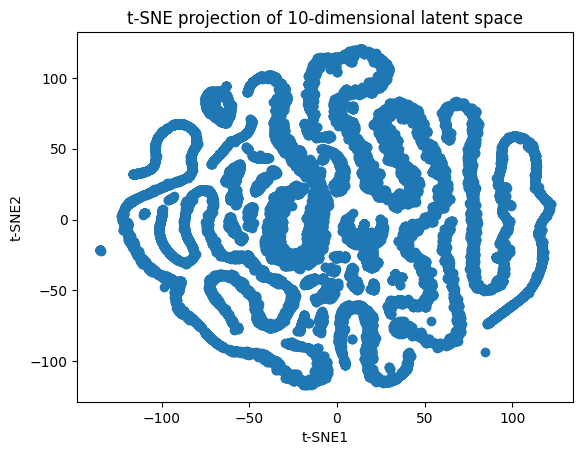

In [16]:
inputs = vae.get_layer('encoder_input').input
z_mean = vae.get_layer('z_mean').output

encoder = Model(inputs, z_mean)
encoded_data = encoder.predict(train_sequences[:,:,1])

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(encoded_data)

plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.title('t-SNE projection of 10-dimensional latent space')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()


## Encode and decode some data points
#encoder = Model(inputs, z_mean)
#encoded_data = encoder.predict(train_sequences)

# Display some of the encoded data
#plt.scatter(encoded_data[:, 0], encoded_data[:, 1])
#plt.xlabel("Dimension 1")
#plt.ylabel("Dimension 2")
#plt.title("Encoded Data")
#plt.show()


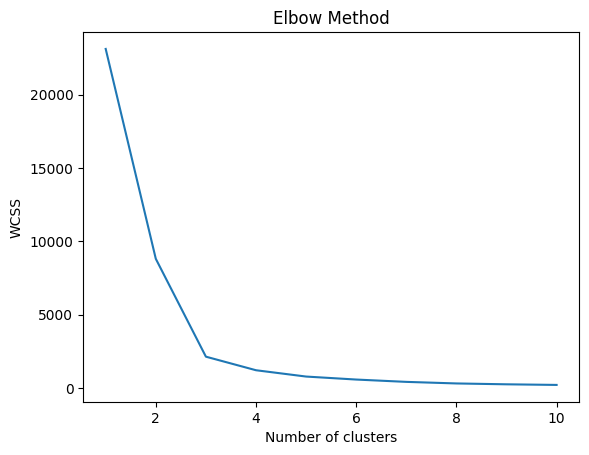

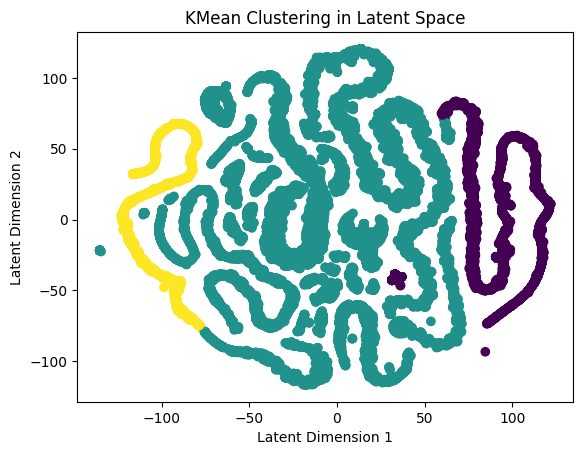

In [18]:
from sklearn.cluster import KMeans
# Determine optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(encoded_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Fit K-Means with optimal clusters
np.random.seed(42)
optimal_clusters = 3  # Example
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans.fit_predict(encoded_data)

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clusters)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('KMean Clustering in Latent Space')
plt.show()



#from sklearn.mixture import GaussianMixture
# Fit GMM to the latent space
#gmm = GaussianMixture(n_components=4, random_state=0).fit(encoded_data)

# Assign cluster labels and get probabilities
#clusters = gmm.predict(encoded_data)
#probabilities = gmm.predict_proba(encoded_data)

# Visualize the clusters in the latent space (for 2D or 3D latent space)
#plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clusters)
#plt.xlabel('Latent Dimension 1')
#plt.ylabel('Latent Dimension 2')
#plt.title('GMM Clustering in Latent Space')
#plt.show()

In [20]:
reconstructed_sequences = vae.predict(train_sequences[:,:,1])

887/887 [==============================] - 16s 18ms/step


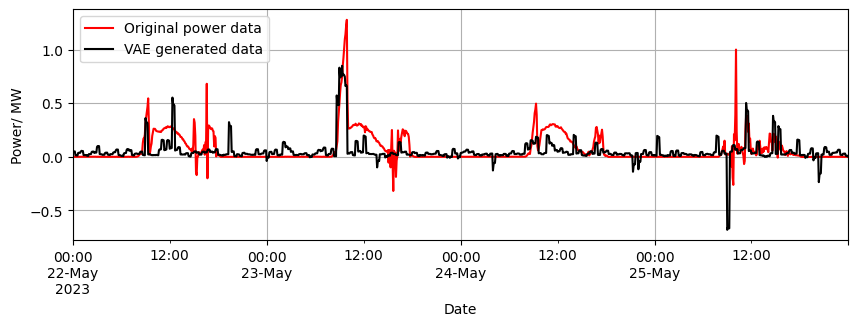

In [22]:
# 1. Reshape sequences back to original form
original_shape = (len(data), 2)
reconstructed_original_data = np.zeros(original_shape)
reconstructed_vae_data = np.zeros(original_shape)

#for i in range(len(train_sequences) - timesteps):
#    reconstructed_original_data[i:i + timesteps] = train_sequences[i]
#    reconstructed_vae_data[i:i + timesteps] = reconstructed_sequences[i]

overlap = 2
num_sequences = (len(data) - timesteps) // timesteps + 1
step_size = timesteps - overlap
for i in range(num_sequences):
    start = i * step_size
    end = start + timesteps
    reconstructed_original_data[start:end] = train_sequences[i]
    reconstructed_vae_data[start:end] = reconstructed_sequences[i]


X_test_original = scaler.inverse_transform(reconstructed_original_data)
X_test_vae = scaler.inverse_transform(reconstructed_vae_data)

df_orginal = pd.DataFrame(data = X_test_original, index = train_data_date, columns = ['Power','Power_error'])
df_vae_output = pd.DataFrame(data = X_test_vae, index = train_data_date, columns = ['Power','Power_error'])



# Define the period you want to plot
start_date = '2023-05-22'
end_date = '2023-05-25'

# Slice the DataFrame based on the specified period
df_orginal_period = df_orginal[start_date:end_date]
df_vae_output_period = df_vae_output[start_date:end_date]


df_orginal_period['Power_error'].resample('5min').mean().plot(figsize=(10, 3), color =['Red'],label='Original power data')
df_vae_output_period['Power_error'].resample('5min').mean().plot(figsize=(10, 3),color =['Black'],label='VAE generated data')
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
array_b = np.zeros((9455, 12, 1))
reconstructed_sequences_temp = np.concatenate([reconstructed_sequences,array_b], axis=-1) 
reconstructed_sequences_temp[:,:,1] = train_sequences[:,:,1]

# Add cluster labels to the original sequences
clusters_temp = np.repeat(clusters[:, None, None], train_sequences.shape[1], axis=1)
original_sequences_with_clusters = np.concatenate([train_sequences, clusters_temp], axis=-1)
reconstructed_sequences_with_clusters = np.concatenate([reconstructed_sequences_temp, clusters_temp], axis=-1)


# Initialize an array to hold cluster IDs for the entire time series
cluster_ids = np.full(len(train_data), -1)

# Map each sequence's cluster ID back to the corresponding indices in the original time series
for i in range(len(train_sequences)):
    start_idx = i * timesteps
    end_idx = start_idx + timesteps
    cluster_ids[start_idx:end_idx] = clusters[i]



'''
# Create a copy of cluster_ids to update with the most frequent cluster ID
updated_cluster_ids = cluster_ids.copy()
# Handle the overlapping indices by assigning the most frequent cluster ID
for i in range(len(cluster_ids) - timesteps + 1):
    window = cluster_ids[i:i + timesteps]
    unique, counts = np.unique(window[window != -1], return_counts=True)  # Ignore unassigned (-1) values
    if len(unique) > 0:  # Ensure there are assigned values in the window
        most_frequent_cluster = unique[np.argmax(counts)]
        updated_cluster_ids[i:i + timesteps] = most_frequent_cluster

'''

'''
# Ensure that the overlapping indices are smoothed out
def smooth_clusters(cluster_ids, timesteps):
    smoothed_cluster_ids = np.copy(cluster_ids)
    half_window = timesteps // 2

    for i in range(len(cluster_ids) - timesteps):
        window_start = i
        window_end = i + timesteps
        window = cluster_ids[window_start:window_end]
        
        # Use a weighted approach to smooth transitions
        unique, counts = np.unique(window, return_counts=True)
        most_frequent_cluster = unique[np.argmax(counts)]
        
        # Gradual transition using weighted average (or simply assign the most frequent cluster)
        for j in range(window_start, window_end):
            smoothed_cluster_ids[j] = most_frequent_cluster

    return smoothed_cluster_ids
'''



# Apply smoothing
#cluster_ids = smooth_clusters(cluster_ids, timesteps)
#cluster_ids = updated_cluster_ids

# Ensure the cluster_ids array has the same length as the original time series
cluster_ids = cluster_ids[:len(train_data)]


'''
# 1. Reshape sequences back to original form
original_shape = (len(train_data), 3)
reconstructed_shape = (len(train_data), 3)
reconstructed_original_data = np.zeros(original_shape)
reconstructed_vae_data = np.zeros(reconstructed_shape)

for i in range(len(train_sequences) - timesteps):
    reconstructed_original_data[i:i + timesteps] = original_sequences_with_clusters[i]
    reconstructed_vae_data[i:i + timesteps] = reconstructed_sequences_with_clusters[i]


reconstructed_original_data[:,0:2] = scaler.inverse_transform(reconstructed_original_data[:,0:2])
reconstructed_vae_data[:,0:2] = scaler.inverse_transform(reconstructed_vae_data[:,0:2])


df_orginal = pd.DataFrame(data = reconstructed_original_data, index = train_data_date, columns = ['Power','Power_error','Clusters'])
df_vae_output = pd.DataFrame(data = reconstructed_vae_data, index = train_data_date, columns = ['Power_error','Power','Clusters'])
'''

df_orginal['Clusters'] = cluster_ids



In [ ]:
start_date = '2023-06-12'
end_date = '2023-06-25'

df_orginal['Power_error'][start_date:end_date].resample('5min').mean().plot(figsize=(15, 4), color =['Blue'],label='Residual Power')
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()


# Check if clusters exist in the date range
for cluster in range(4):
    cluster_data = df_orginal.query('Clusters == @cluster')[start_date:end_date]
    if not cluster_data.empty:
        cluster_data['Power_error'].resample('5min').mean().plot(
            figsize=(15, 4),
            color=['Red', 'Black', 'Pink', 'Green'][cluster],
            label=f'Cluster {cluster}'
        )


# Add labels, grid, and legend
plt.ylabel('Residual power')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.show()